In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
import argparse

pd.set_option('display.max_rows', None)

In [2]:
#define functions to process data

def drop_obs(all_orig_obsdata):
    #drop any observatinos from 1 region that aren't in another (make sure they all have same # of obs)
    #do this by looking at the observation names in the dataframe,
    # dropping any that aren't presesent in all of the regions provided
    #RETURNS: list of region/obsdata dataframes, with uncommon observations dropped
    
    #find common observations between the 3 different regions
    common_obs = pd.Series(list(set(all_orig_obsdata[0].Observation) \
                                & set(all_orig_obsdata[1].Observation)\
                                & set(all_orig_obsdata[2].Observation)))
    
    
    #store all of the obsdata with uncommon obs dropped
    all_dropped_obsdata = []
    
    #for each region, remove observations not in the list of common observations
    for obsdata in all_orig_obsdata:
        
        #keep only observations in the common list
        obsdata = obsdata[obsdata.Observation.isin(common_obs)]
        
        #reset indices (so they all match)
        obsdata = obsdata.reset_index(drop=True)
        
        #save list of observations (now having dropped any not in common)
        all_dropped_obsdata.append(obsdata)
        
    
    return all_dropped_obsdata
        
    

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Final unique observation names:', len(obsdata))
    print()
    
    return obsdata



def small_ei(obsdata):
    #Find "small" (<6) e or i
    #obsdata: dataframe, processed to have EQX obs removed
    #returns: 
        #low-phase obsdata (phase < 60)
        #low-phase low-ei mask
        #low-ei mask
    
    low_phase_mask = obsdata['Mean Phase'] <= 60
    low_phase_obsdata = obsdata[low_phase_mask]
    lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
    lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
    lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

    low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
    low_i_mask = np.abs(obsdata['Incidence']-90) < 6
    low_ei_mask = low_e_mask | low_i_mask
    
    return low_phase_obsdata, lp_low_ei_mask, low_ei_mask

In [3]:
#Finding tau, phase curve values for JUST the outer skirt regions
#Basically like the 3-region analyze_tau version, but not including the core at all

#use all 3 regions, 4 boundaries between the regions
radii = ['139220', '140120', '140320', '141220']

#degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

dump_ew_dir = '~/REU_2022/data/dump_ew_csv/'

In [4]:
# Set the filepath for the 3 csv files to read in based on parameters

size = '0' #slice/step size of the csv file, currently only have 0

#read in the 3 different csv files
filepath1 = dump_ew_dir+'inner/rin'+radii[0]+'_rout'+radii[1]+'/slice'+size+'_ew_stats.csv'
filepath2 = dump_ew_dir+'core/rin'+radii[1]+'_rout'+radii[2]+'/slice'+size+'_ew_stats.csv'
filepath3 = dump_ew_dir+'outer/rin'+radii[2]+'_rout'+radii[3]+'/slice'+size+'_ew_stats.csv'

filepaths = [filepath1, filepath2, filepath3]

In [5]:
#create lists to store each of the 3 regions' data in
all_orig_obsdata = []
all_obsdata = []
all_low_phase_obsdata = []
all_lp_low_ei_masks = []
all_low_ei_masks = []

In [6]:
# Read the data and dump statistics

for filepath in filepaths:
    orig_obsdata = pd.read_csv(filepath, parse_dates=['Date']); ms=20; alpha=0.7
      
    print('** SUMMARY STATISTICS **')
    print('Unique observation names:', len(orig_obsdata.groupby('Observation')))
    print('Total slices:', len(orig_obsdata))
    print('Starting date:', orig_obsdata['Date'].min())
    print('Ending date:', orig_obsdata['Date'].max())
    print('Time span:', orig_obsdata['Date'].max()-orig_obsdata['Date'].min())
    print()
    
    all_orig_obsdata.append(orig_obsdata)

print()


#make sure all of the regions have the same number of observations (drop any that don't match)
all_orig_obsdata = drop_obs(all_orig_obsdata)


#remove EQX observations
for orig_obsdata in all_orig_obsdata:
    
    obsdata = remove_eqx(orig_obsdata, eqx_cutoff)
    all_obsdata.append(obsdata)

print()

** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

** SUMMARY STATISTICS **
Unique observation names: 148
Total slices: 148
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39


Removed OBSIDs: {'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_114RF_FMOVIEEQX001_PRIME'}
Final unique observation names: 146

Removed OBSIDs: {'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_114RF_FMOVIEEQX001_PRIME'}
Final unique observation names: 146

Removed OBSIDs: {'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_114RF_FMOVIEEQX001_PRIME'}
Final unique observation names: 146




In [7]:
#check to make sure the 3 regions all have the same number of observations
assert len(all_obsdata[0]) == len(all_obsdata[1]) == len(all_obsdata[2]),\
        'Regions do not have the same number of observations'

# Optimize Tau for Low-Phase Observations

In [8]:
#find small ei observations (<6)
for obsdata in all_obsdata:
    low_phase_obsdata, lp_low_ei_mask, low_ei_mask = small_ei(obsdata)
    
    all_low_phase_obsdata.append(low_phase_obsdata)
    all_lp_low_ei_masks.append(lp_low_ei_mask)
    all_low_ei_masks.append(low_ei_mask)

#low ei masks the same for each, since same across whole observation
lp_low_ei_mask = all_lp_low_ei_masks[0]
low_ei_mask = all_low_ei_masks[0]

In [9]:
#find the best-fit tau
#(use all 3 regions' added-together EW to optimize, but only apply tau to core region)

best_tau = None
best_ratio = 1e38
for tau in np.arange(0.000, 0.051, 0.001):
    
    #get JUST the regular EW values for the inner, outer areas (tau = 0)
    inner_corrected_ew = compute_corrected_ew(all_low_phase_obsdata[0]['Normal EW'], 
                                            all_low_phase_obsdata[0]['Mean Emission'], 
                                            all_low_phase_obsdata[0]['Incidence'], 
                                            tau=tau)
    outer_corrected_ew = compute_corrected_ew(all_low_phase_obsdata[2]['Normal EW'], 
                                            all_low_phase_obsdata[2]['Mean Emission'], 
                                            all_low_phase_obsdata[2]['Incidence'], 
                                            tau=tau)
    
        
    #add both EW values together to get the full skirt EW value to compute scatter on
    corrected_ew = inner_corrected_ew + outer_corrected_ew
    
    mean_low = np.mean(corrected_ew[lp_low_ei_mask])
    mean_notlow = np.mean(corrected_ew[~lp_low_ei_mask])
    if abs(mean_notlow/mean_low-1) < best_ratio:
        best_ratio = abs(mean_notlow/mean_low-1)
        best_tau = tau
    if abs(mean_low/mean_notlow-1) < best_ratio:
        best_ratio = abs(mean_low/mean_notlow-1)
        best_tau = tau
    print(f'Tau {tau:.3f} - Mean Normal EW Low E/I: {mean_low:8.5f} '
          f'EW Other: {mean_notlow:8.5f} '
          f'Ratio: {mean_notlow/mean_low:5.3f}')

print()
print(f'** Best Tau: {best_tau:.3f}')

print()
print('Uncorrected Low Phase:')
uc_mean_low = np.mean(low_phase_obsdata['Normal EW'][lp_low_ei_mask])
uc_mean_notlow = np.mean(low_phase_obsdata['Normal EW'][~lp_low_ei_mask])
print(f'Mean Normal EW Low E/I: {uc_mean_low:.5f}')
print(f'Mean Normal EW Other:   {uc_mean_notlow:.5f}')
print(f'Other/Low: {uc_mean_notlow/uc_mean_low:.5f}')
print()

inner_lp_corrected_ew = all_low_phase_obsdata[0]['Normal EW']
outer_lp_corrected_ew = all_low_phase_obsdata[2]['Normal EW']

lp_corrected_ew = inner_lp_corrected_ew + outer_lp_corrected_ew

mean_low = np.mean(lp_corrected_ew[lp_low_ei_mask])
mean_notlow = np.mean(lp_corrected_ew[~lp_low_ei_mask])
print(f'Corrected (tau={best_tau:.3f}) Low Phase:')
print(f'Mean Normal EW Low E/I: {mean_low:.5f}')
print(f'Mean Normal EW Other:   {mean_notlow:.5f}')
print(f'Other/Low: {mean_notlow/mean_low:.5f}')

print()
print('Overall change due to Tau:')
print(f'Mean Normal EW Low E/I: {mean_low/uc_mean_low:.5f}')
print(f'Mean Normal EW Other:   {mean_notlow/uc_mean_notlow:.5f}')

Tau 0.000 - Mean Normal EW Low E/I:  0.23530 EW Other:  0.18160 Ratio: 0.772
Tau 0.001 - Mean Normal EW Low E/I:  0.23805 EW Other:  0.18227 Ratio: 0.766
Tau 0.002 - Mean Normal EW Low E/I:  0.24082 EW Other:  0.18294 Ratio: 0.760
Tau 0.003 - Mean Normal EW Low E/I:  0.24364 EW Other:  0.18362 Ratio: 0.754
Tau 0.004 - Mean Normal EW Low E/I:  0.24649 EW Other:  0.18430 Ratio: 0.748
Tau 0.005 - Mean Normal EW Low E/I:  0.24937 EW Other:  0.18498 Ratio: 0.742
Tau 0.006 - Mean Normal EW Low E/I:  0.25230 EW Other:  0.18567 Ratio: 0.736
Tau 0.007 - Mean Normal EW Low E/I:  0.25526 EW Other:  0.18635 Ratio: 0.730
Tau 0.008 - Mean Normal EW Low E/I:  0.25825 EW Other:  0.18704 Ratio: 0.724
Tau 0.009 - Mean Normal EW Low E/I:  0.26129 EW Other:  0.18774 Ratio: 0.719
Tau 0.010 - Mean Normal EW Low E/I:  0.26436 EW Other:  0.18843 Ratio: 0.713
Tau 0.011 - Mean Normal EW Low E/I:  0.26747 EW Other:  0.18913 Ratio: 0.707
Tau 0.012 - Mean Normal EW Low E/I:  0.27062 EW Other:  0.18983 Ratio: 0.701

In [10]:
#find H-G phase curve for full dataset (not just low-phase data)

#get combined value for uncorrected_ew
inner_uc_ew = all_obsdata[0]['Normal EW']
outer_uc_ew = all_obsdata[2]['Normal EW']

uc_ew = inner_uc_ew + outer_uc_ew

#get combined value for corrected_ew
inner_corrected_ew = all_obsdata[0]['Normal EW']
outer_corrected_ew = all_obsdata[2]['Normal EW']

corrected_ew = inner_corrected_ew + outer_corrected_ew


#make dataframes including the 3-region-combined ew values in the 'Normal EW' col (both uc and corrected)
#(other parameters, e.g. mean phase, mean emission should be the same)
uc_obsdata = all_obsdata[0]
obsdata = all_obsdata[0] 

#replace Normal EW values (drop old Normal EW column, add new one in)
uc_obsdata = uc_obsdata.drop(['Normal EW'], axis=1)
uc_obsdata.insert(loc=18, column='Normal EW', value=uc_ew)

obsdata = obsdata.drop(['Normal EW'], axis=1)
obsdata.insert(loc=18, column='Normal EW', value=corrected_ew)

#fit the H-G curve for the uncorrected and corrected values
#use tau=None for both, since tau correction already applied to Normal EW
uc_hg_params, uc_hg_used_data, uc_hg_std = fit_hg_phase_function(2, None, uc_obsdata, 
                                                                 verbose=False)
print()
print('Uncorrected H-G params:')
print_hg_params(uc_hg_params, indent=2)
print(f'  Standard deviation: {uc_hg_std:.5f}')

hg_params, hg_used_data, hg_std = fit_hg_phase_function(2, None, obsdata,
                                                        verbose=False)
print()
print(f'Corrected (tau={best_tau:.3f}) params:')
print_hg_params(hg_params, indent=2)
print(f'  Standard deviation: {hg_std:.5f}')


Uncorrected H-G params:
  g1 = 0.657 weight1 = 0.746
  g2 = -0.114 weight2 = 0.254
  Standard deviation: 0.09459

Corrected (tau=0.000) params:
  g1 = 0.657 weight1 = 0.746
  g2 = -0.114 weight2 = 0.254
  Standard deviation: 0.09459


In [11]:
#combine data for low_phase_obsdata uncorrected and corrected in similar fashion to full obsdata
#lp_uc_obsdata (create, add in lp 3-combined Normal EW)
#lp_corrected_obsdata (add in lp_corrected_ew to Normal EW)
inner_lp_uc_ew = all_low_phase_obsdata[0]['Normal EW']
outer_lp_uc_ew = all_low_phase_obsdata[2]['Normal EW']

lp_uc_ew = inner_lp_uc_ew + outer_lp_uc_ew

lp_uc_obsdata = all_low_phase_obsdata[0]
lp_uc_obsdata = lp_uc_obsdata.drop(['Normal EW'], axis=1)
lp_uc_obsdata.insert(loc=18, column='Normal EW', value=lp_uc_ew)

#do the same for lp_corrected_ew (already exists)
#lp_corrected_obsdata = all_low_phase_obsdata[0]
#lp_corrected_obsdata = lp_corrected_obsdata.drop(['Normal EW'], axis=1)
#lp_corrected_obsdata.insert(loc=18, column='Normal EW', value=lp_corrected_ew)

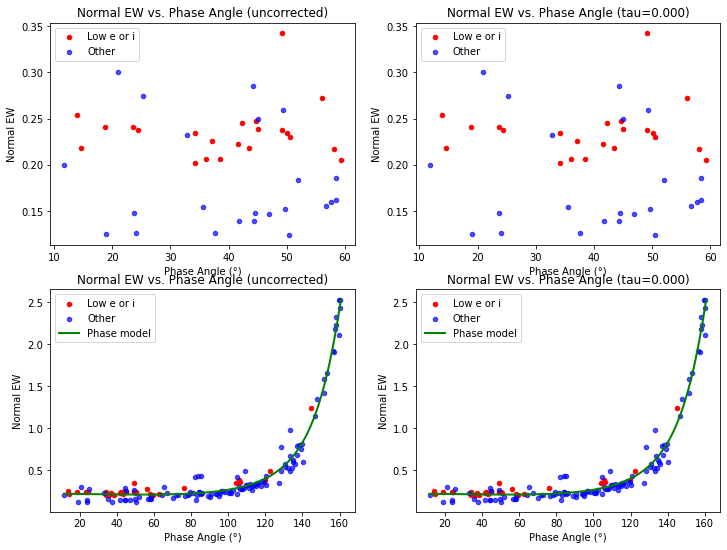

In [12]:
#plot results
plt.figure(figsize=(12,9))
plt.subplot(2, 2, 1)
plt.scatter(lp_uc_obsdata['Mean Phase'][lp_low_ei_mask], 
            lp_uc_obsdata['Normal EW'][lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(lp_uc_obsdata['Mean Phase'][~lp_low_ei_mask], 
            lp_uc_obsdata['Normal EW'][~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(2, 2, 2)
plt.scatter(lp_uc_obsdata['Mean Phase'][lp_low_ei_mask], 
            lp_corrected_ew[lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(lp_uc_obsdata['Mean Phase'][~lp_low_ei_mask], 
            lp_corrected_ew[~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')

plt.subplot(2, 2, 3)
plt.scatter(uc_obsdata['Mean Phase'][low_ei_mask], 
            uc_obsdata['Normal EW'][low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(uc_obsdata['Mean Phase'][~low_ei_mask], 
            uc_obsdata['Normal EW'][~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
uc_hg_phase_model = hg_func(uc_hg_params, np.radians(xrange))
plt.plot(xrange, uc_hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(2, 2, 4)
plt.scatter(obsdata['Mean Phase'][low_ei_mask], 
            corrected_ew[low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(obsdata['Mean Phase'][~low_ei_mask], 
            corrected_ew[~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
hg_phase_model = hg_func(hg_params, np.radians(xrange))
plt.plot(xrange, hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')
plt.show()